In [ ]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import set_config
import seaborn as sns
import numpy as np
import warnings

In [2]:
warnings.filterwarnings('ignore')
set_config(transform_output="pandas")

In [11]:
target_column = "num_sold"

In [4]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 150)

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

data = pd.concat([train, test]).reset_index(drop=True)
data_copy = data.copy()

In [6]:
data.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       98550 non-null  int64 
 1   date     98550 non-null  object
 2   country  98550 non-null  object
 3   store    98550 non-null  object
 4   product  98550 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


A lot of data for us here. Around 200K of purely training set. Smaller folds would be ok i think. Interestingly, we have 8,000 num_sold missing from train data. Other than that, no missing values for other features. Additionally, num_sold is purely integers which does make sense.

<Axes: xlabel='store', ylabel='count'>

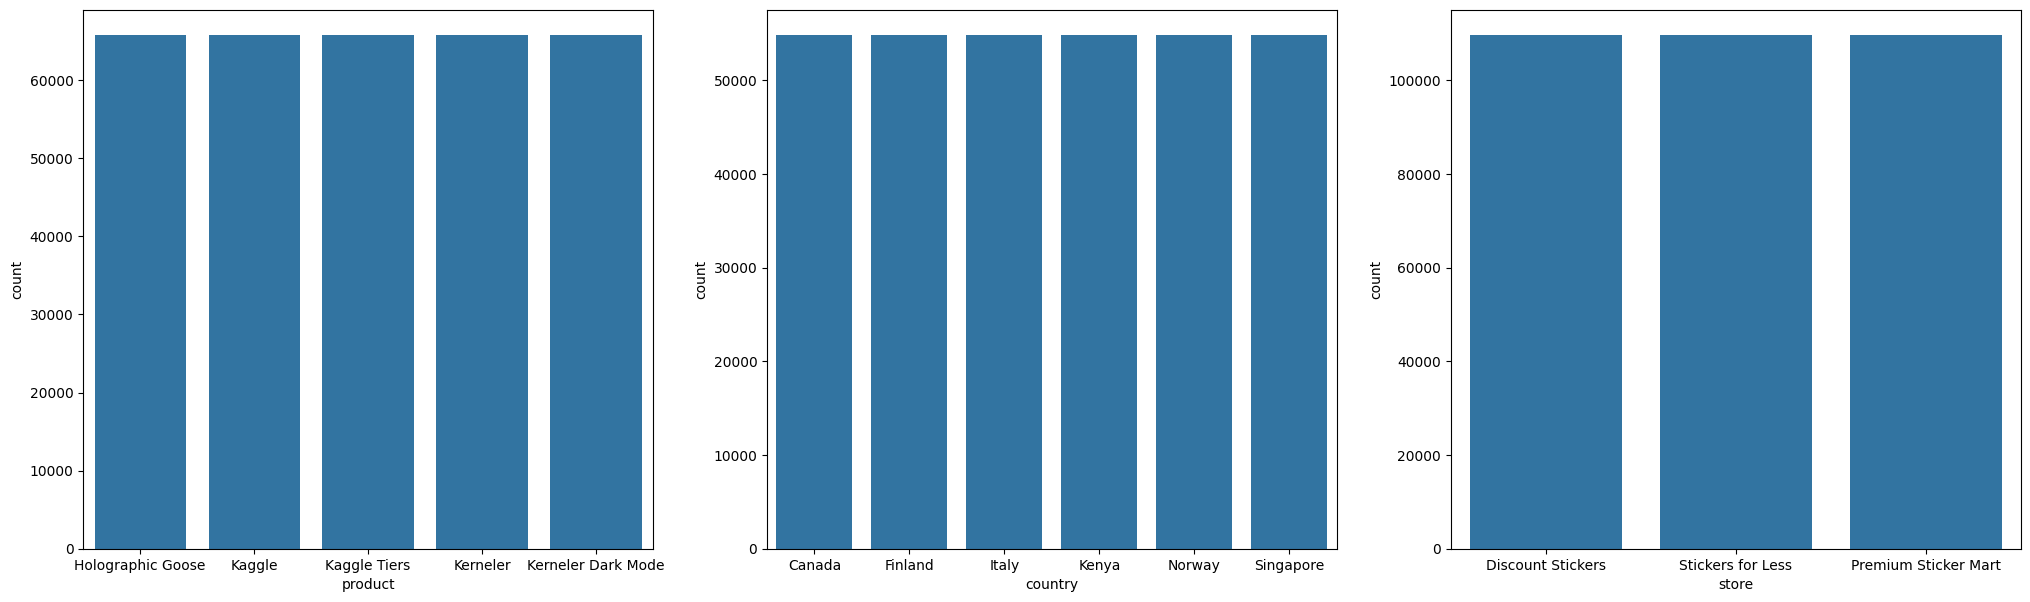

In [ ]:
fig, axs = plt.subplots(figsize=(25,7), ncols=3)

sns.countplot(data, x="product", ax=axs[0])
sns.countplot(data, x="country", ax=axs[1])
sns.countplot(data, x="store", ax=axs[2])

Distribution of the 3 categories across the train and test set are similar. 

<Axes: xlabel='num_sold'>

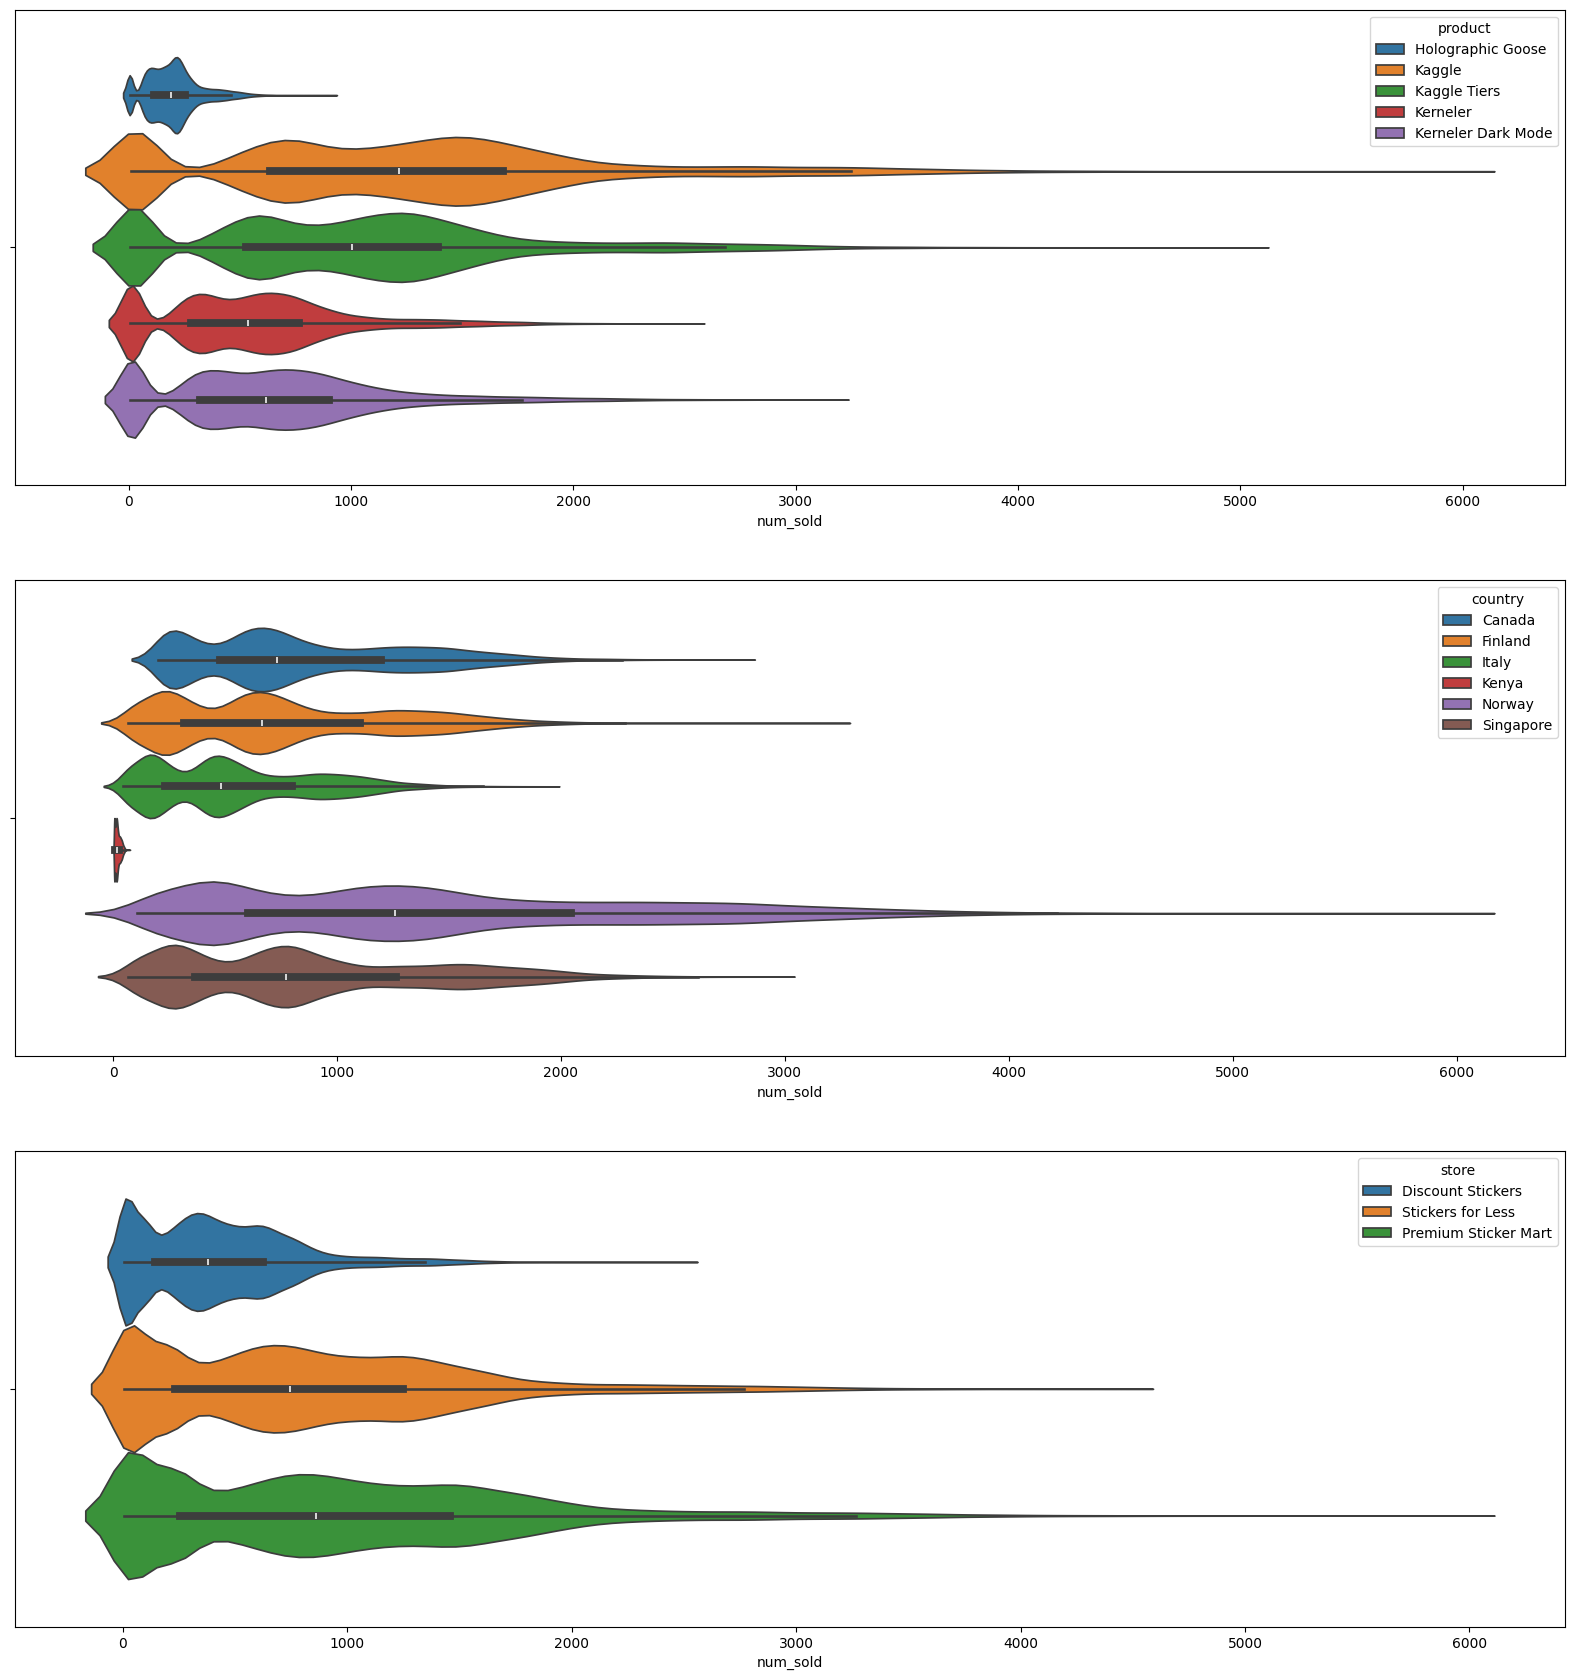

In [ ]:
fig, axs = plt.subplots(figsize=(20,21), nrows=3)

sns.violinplot(data, x=target_column, hue="product",ax=axs[0])
sns.violinplot(data, x=target_column, hue="country",ax=axs[1])
sns.violinplot(data, x=target_column, hue="store",ax=axs[2])

Interestingly, U.S is not on this list of countries. Additionally, sticker sales go down as expected but quickly rise up again. Logarithm distribution for store sales is expected. This could be because there are bulk stickers sales which adds up to the count. Holographic Goose is the most unpopular on this list. Kenya has barely any sales. Premium Sticker Mart is the most popular store.

<Axes: xlabel='store', ylabel='count'>

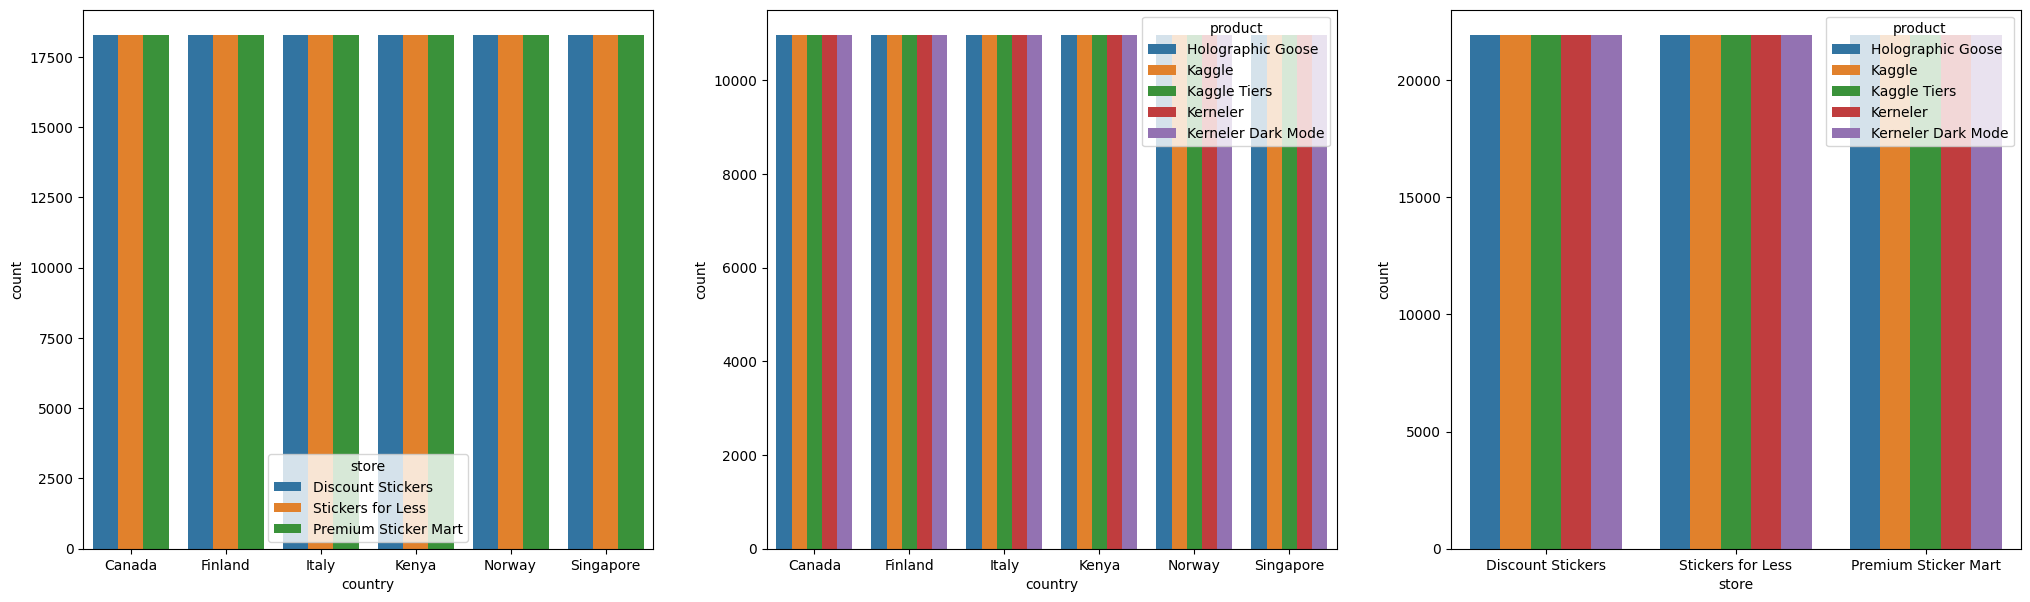

In [36]:
fig, axs = plt.subplots(figsize=(25,7), ncols=3)

sns.countplot(data, x="country", hue="store",ax=axs[0])
sns.countplot(data, x="country", hue="product",ax=axs[1])
sns.countplot(data, x="store", hue="product",ax=axs[2])

Distribution of pair wise categorical features are also similar across all categories. 

In [39]:
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])
data["date"] = pd.to_datetime(data["date"])

Convert date to datetime object

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328680 entries, 0 to 328679
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        328680 non-null  int64         
 1   date      328680 non-null  datetime64[ns]
 2   country   328680 non-null  object        
 3   store     328680 non-null  object        
 4   product   328680 non-null  object        
 5   num_sold  221259 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 15.0+ MB


In [65]:
print(train["date"].min(), train["date"].max())
print(test["date"].min(), test["date"].max())

2010-01-01 00:00:00 2016-12-31 00:00:00
2017-01-01 00:00:00 2019-12-31 00:00:00


For training set, earliest sticker sale date is 2010 of 1st Jan. We have the sold data until 2016 of December 31st. For testing set, we have to predict the day after which is 2017 of Jan 1st until 2019 of December 31st. We have 6 years of training data and then we have to predict the rest 3 remaining years of sales data. 

In [74]:
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["dayofweek"] = data["date"].dt.dayofweek

<Axes: xlabel='num_sold'>

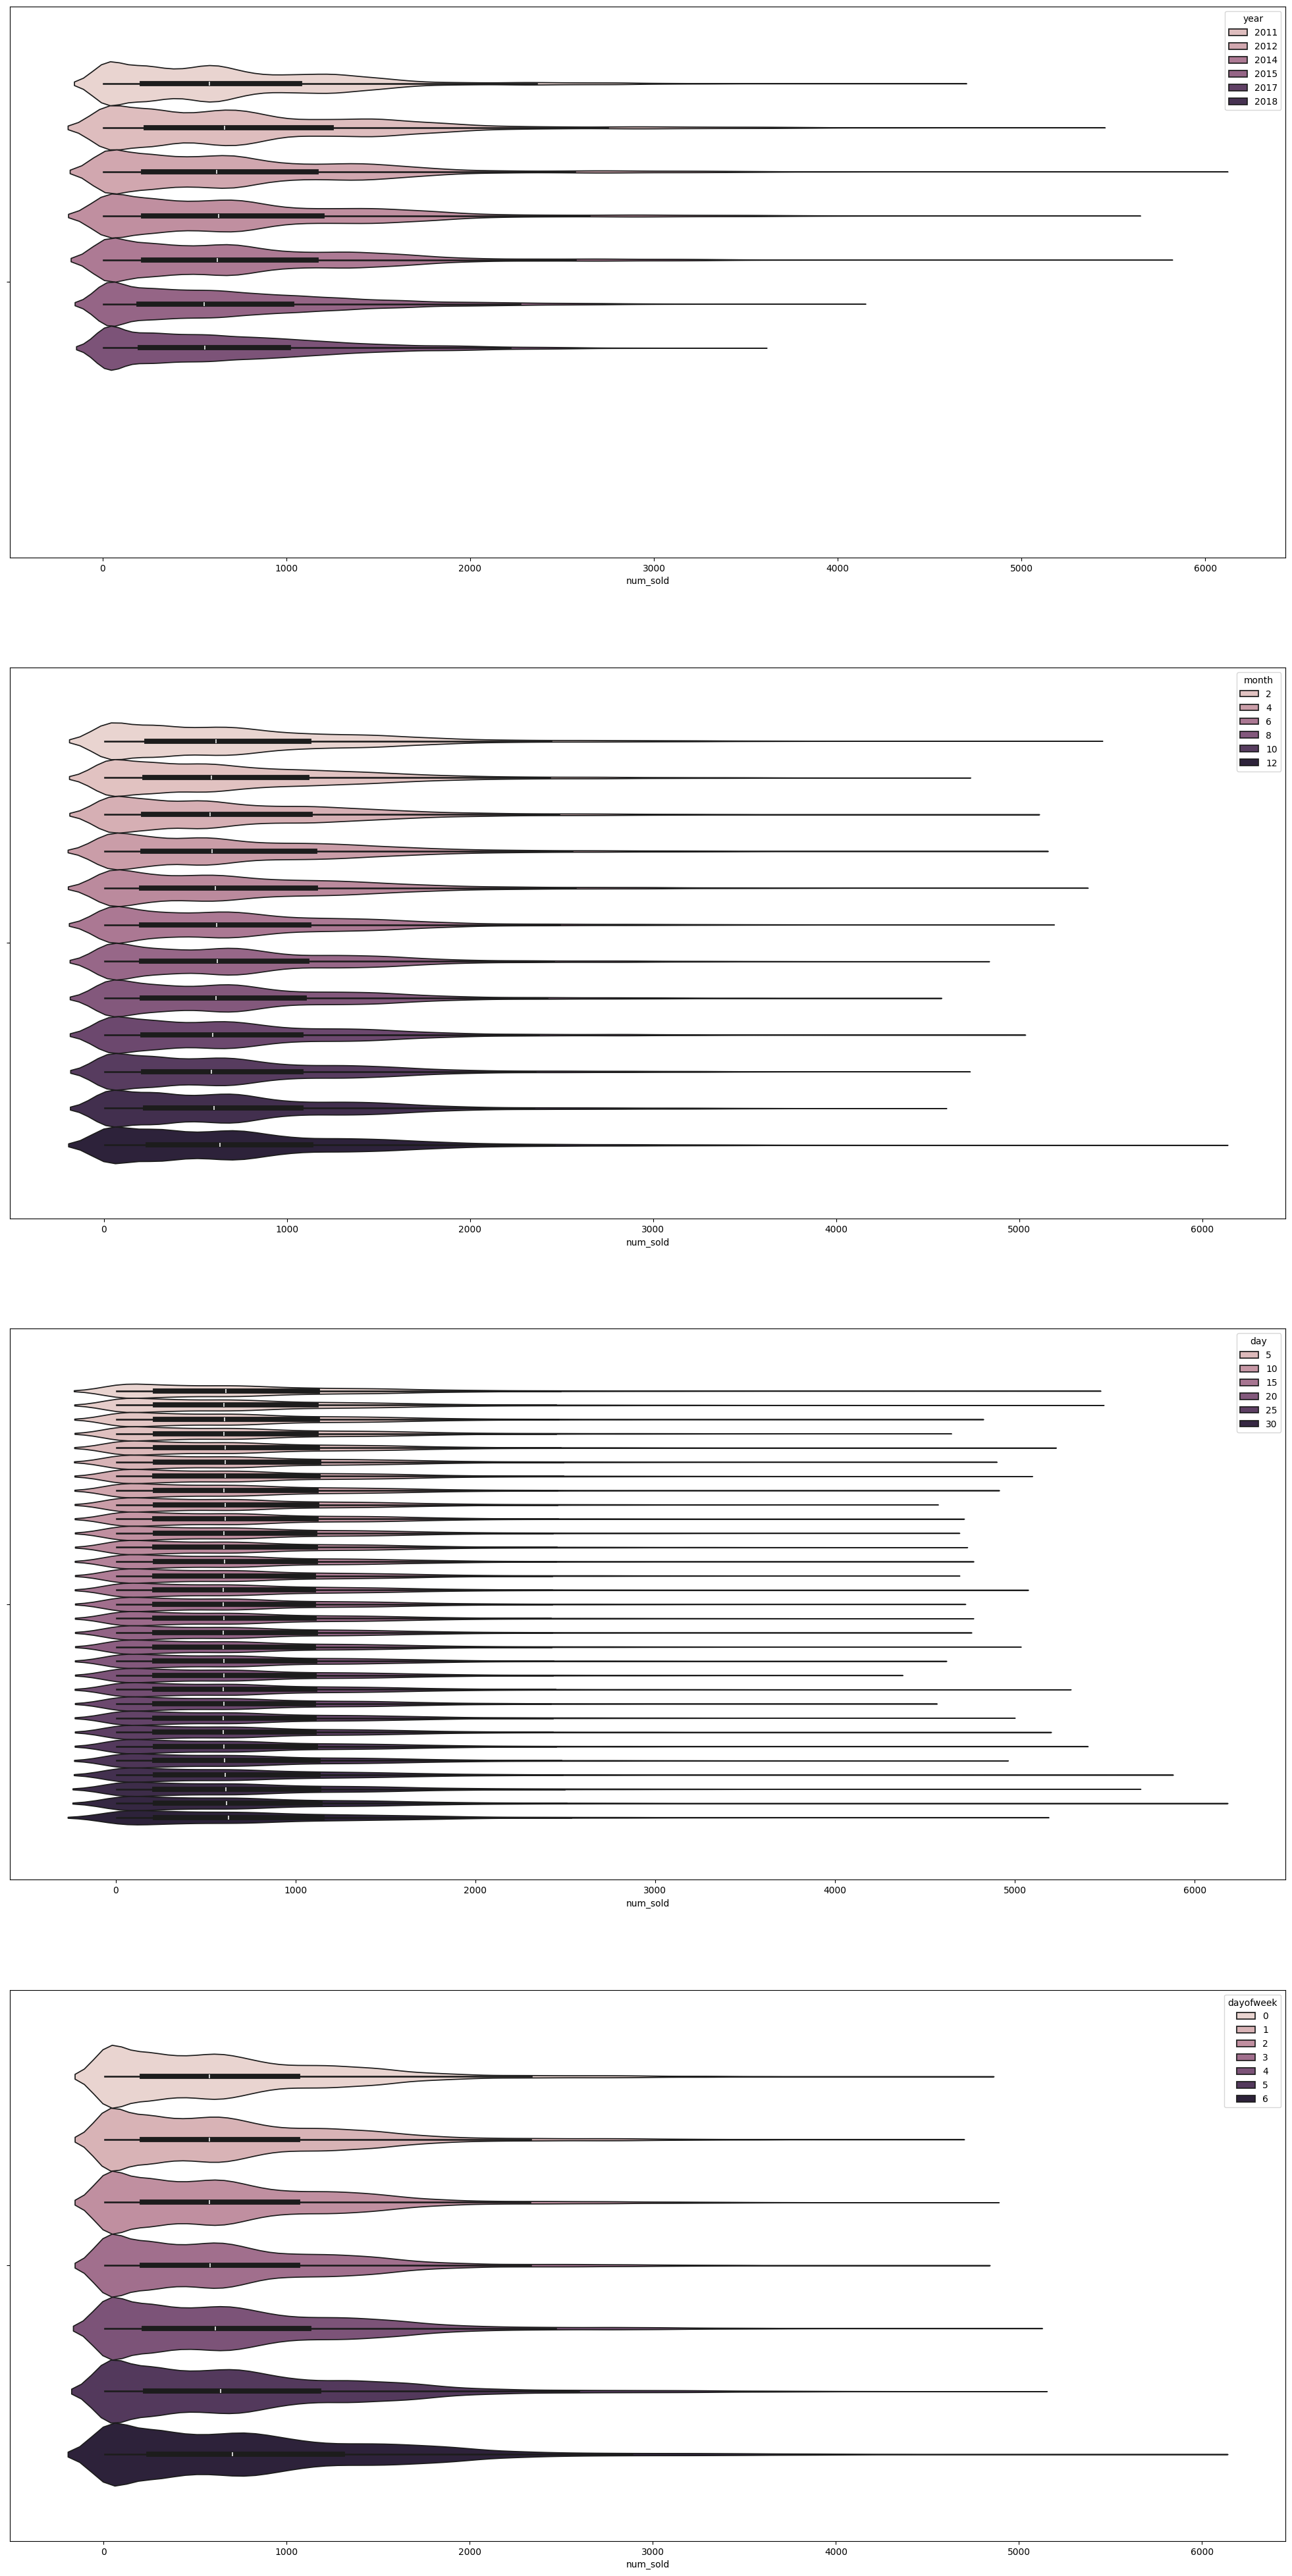

In [76]:
fig, axs = plt.subplots(figsize=(25, 50), nrows=4)

sns.violinplot(data,x=target_column,hue="year",ax=axs[0])
sns.violinplot(data,x=target_column,hue="month",ax=axs[1])
sns.violinplot(data,x=target_column,hue="day",ax=axs[2])
sns.violinplot(data,x=target_column,hue="dayofweek",ax=axs[3])

Looking at the years and num_sold, it looks like the num_sold is almost cycling like a wave across the years. Same cyclic pattern is shown for month and day of month. If we look at day of the week, we see that Saturdays and Sundays have the highest num_sold which should make sense. It also looks like December is a really active month with highest number of sold stickers per that month. 

<Axes: xlabel='days_since_start', ylabel='num_sold'>

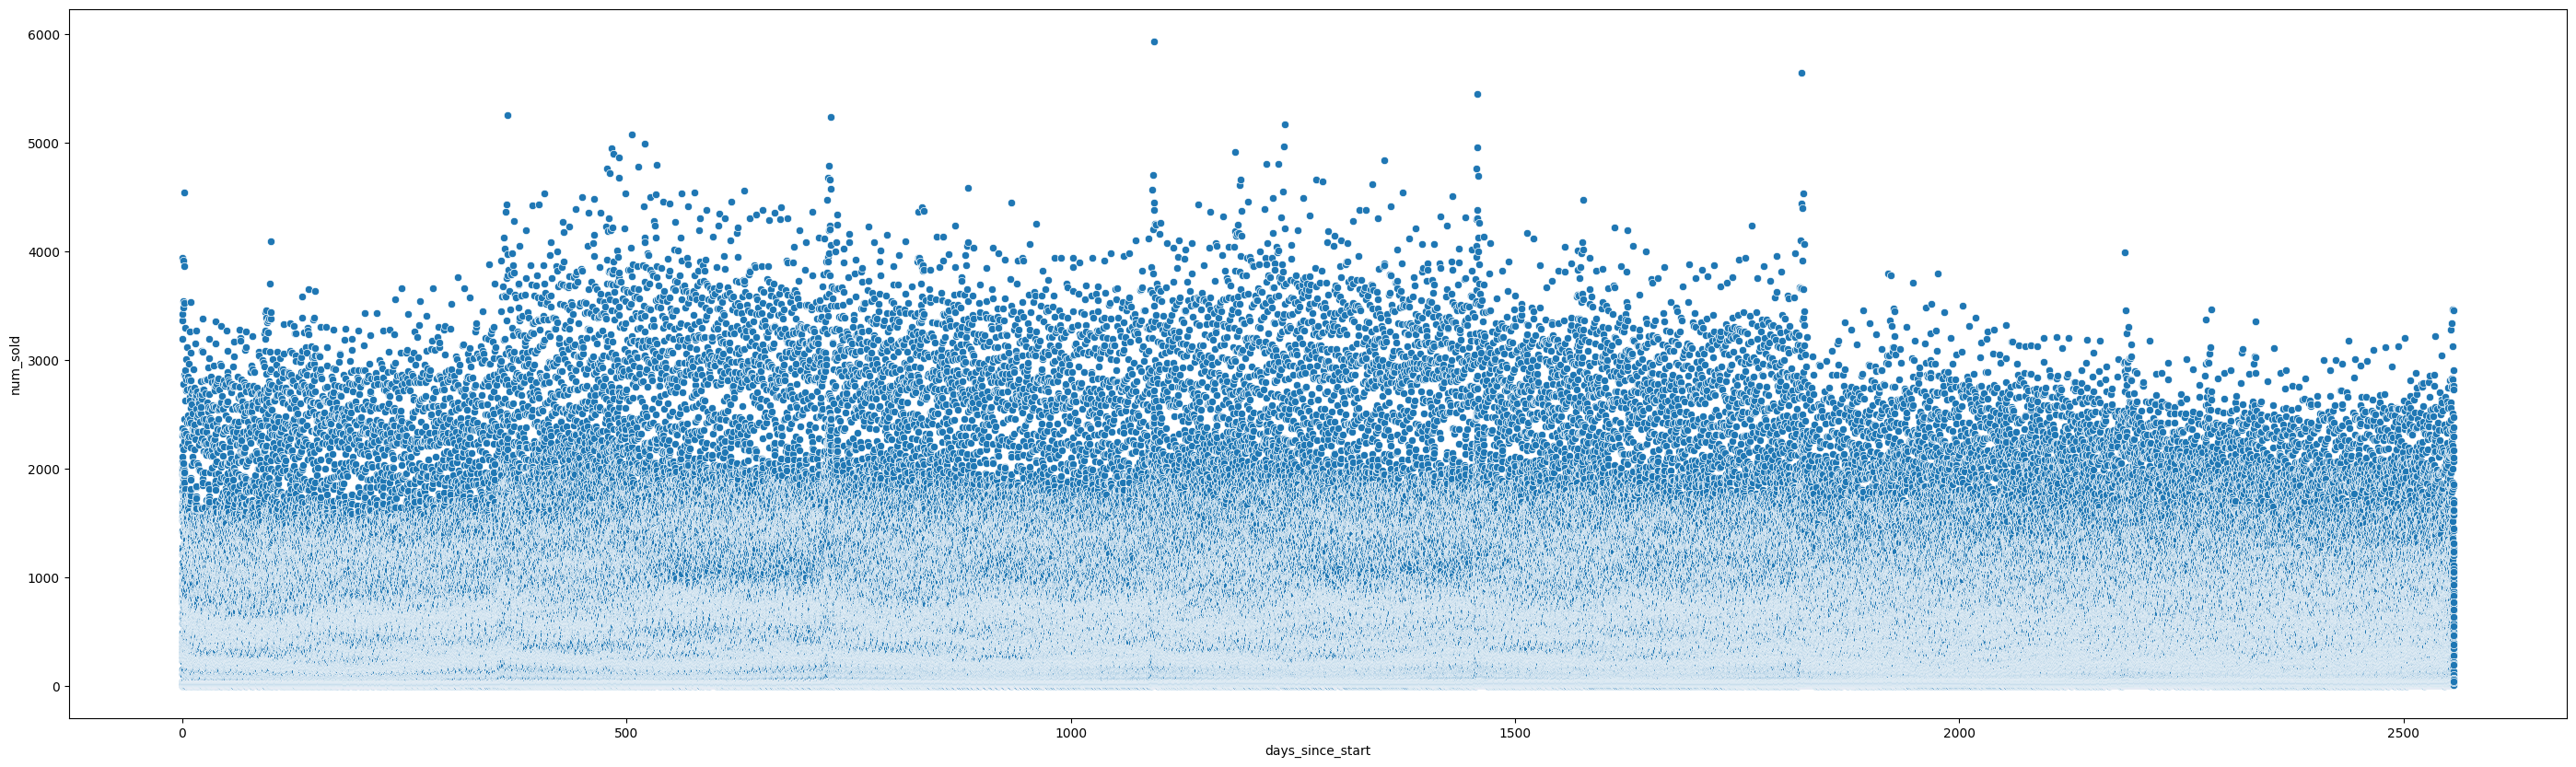

In [89]:
data["days_since_start"] = (data["date"] - data.iloc[0].date).dt.days

fig, axs = plt.subplots(figsize=(35, 10))

sns.scatterplot(data,x="days_since_start",y=target_column)

This pattern surely looks cyclic and num_sold is periodic and not just monotonically increasing or decreasing. 

<Axes: xlabel='dayofweek', ylabel='count'>

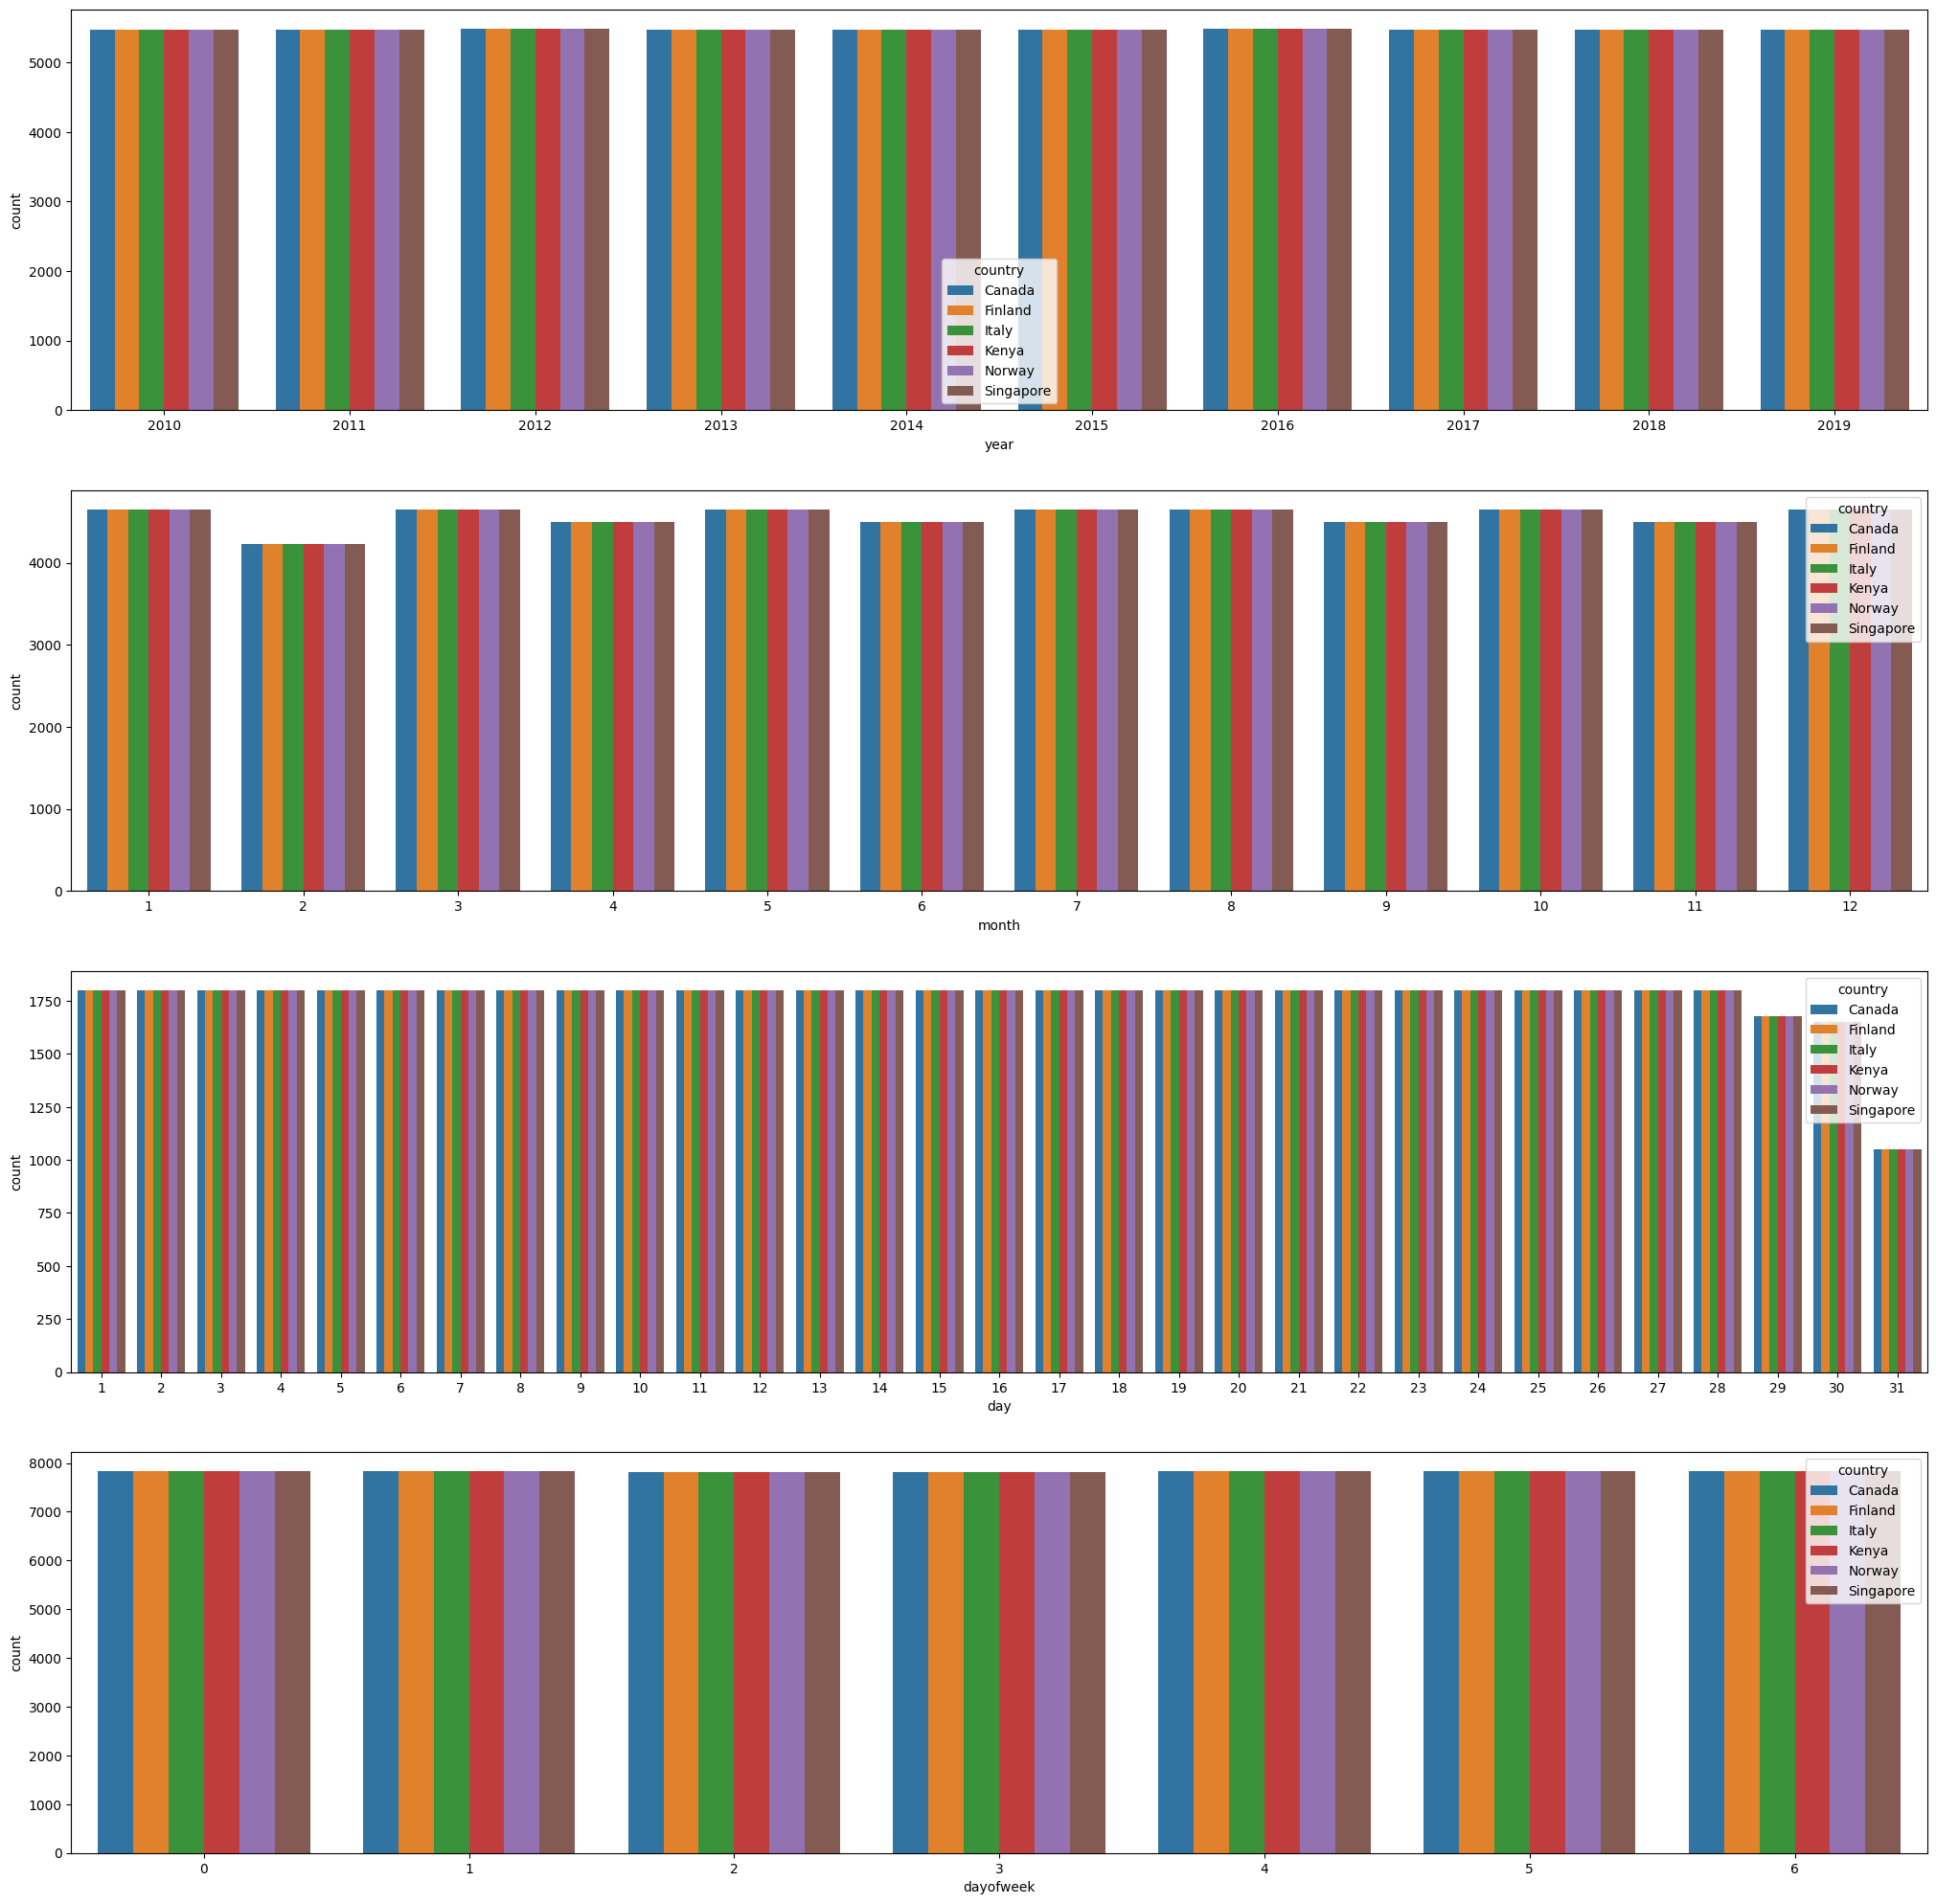

In [95]:
fig, axs = plt.subplots(figsize=(25, 25), nrows=4)

sns.countplot(data,x="year",hue="country",ax=axs[0])
sns.countplot(data,x="month",hue="country",ax=axs[1])
sns.countplot(data,x="day",hue="country",ax=axs[2])
sns.countplot(data,x="dayofweek",hue="country",ax=axs[3])

No unique patterns across different countries when it comes to the date parts.

<Axes: xlabel='dayofweek', ylabel='count'>

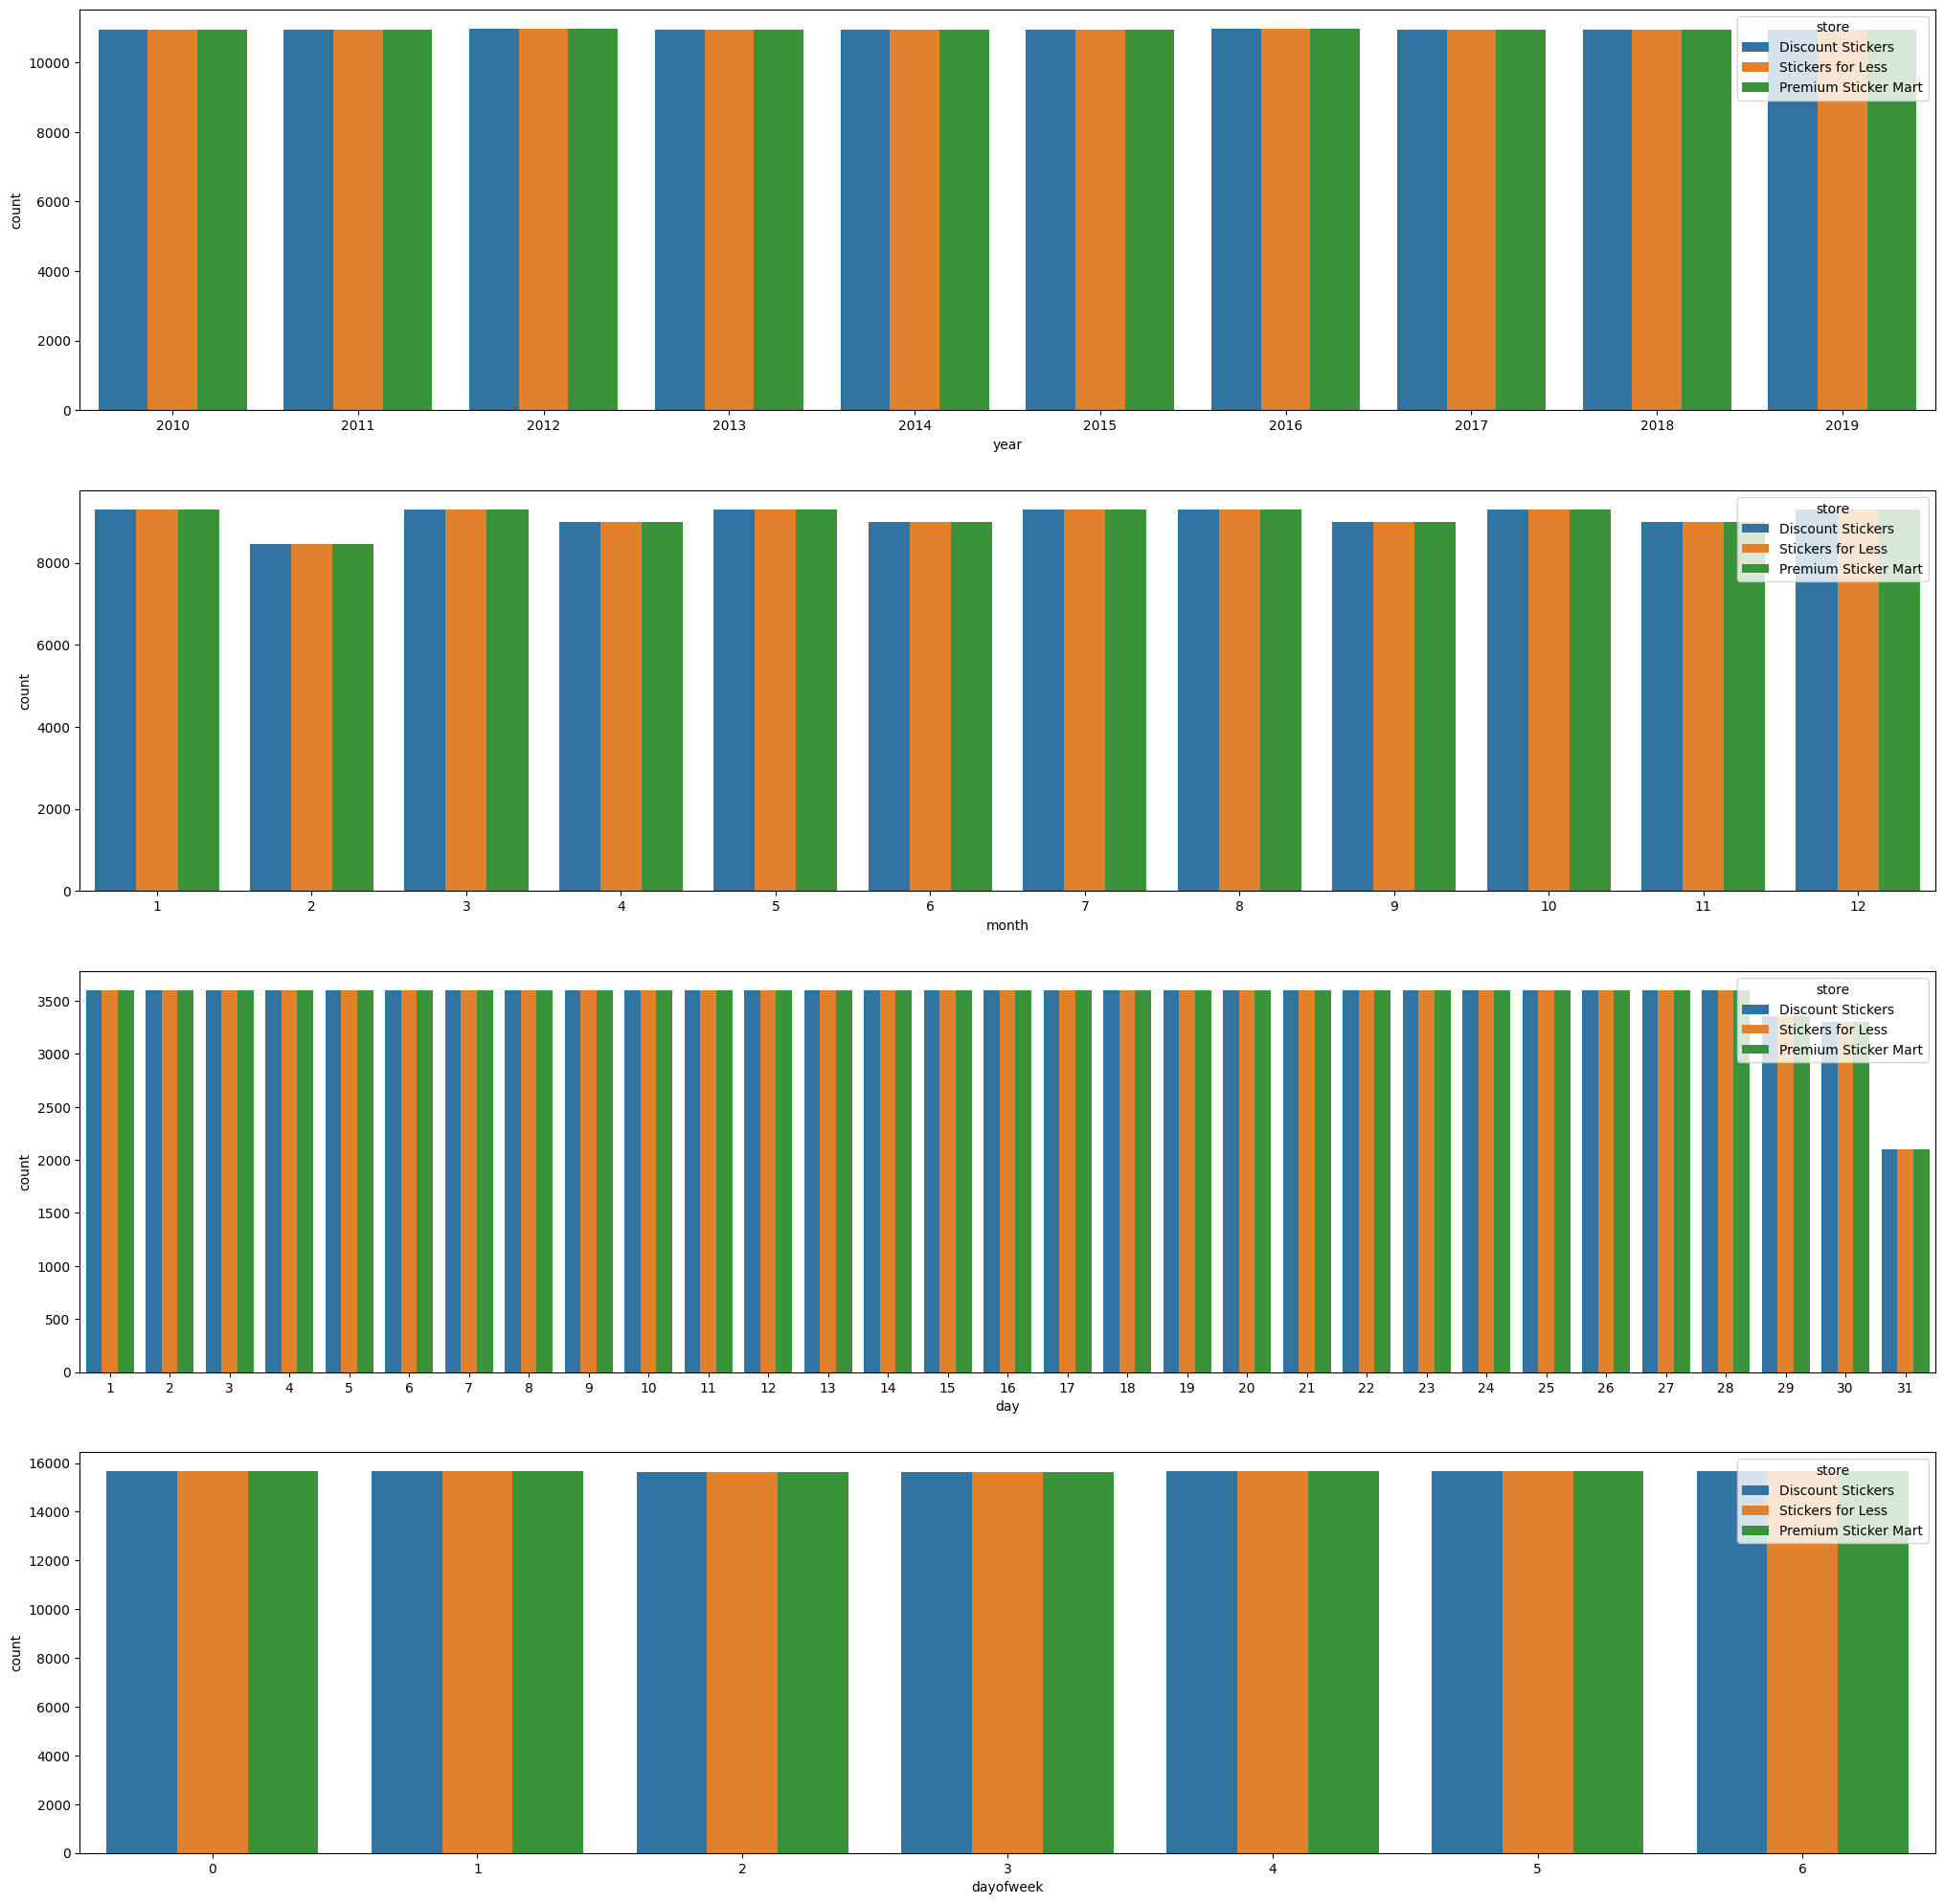

In [96]:
fig, axs = plt.subplots(figsize=(25, 25), nrows=4)

sns.countplot(data,x="year",hue="store",ax=axs[0])
sns.countplot(data,x="month",hue="store",ax=axs[1])
sns.countplot(data,x="day",hue="store",ax=axs[2])
sns.countplot(data,x="dayofweek",hue="store",ax=axs[3])

Similar situation for different stores.

<Axes: xlabel='dayofweek', ylabel='count'>

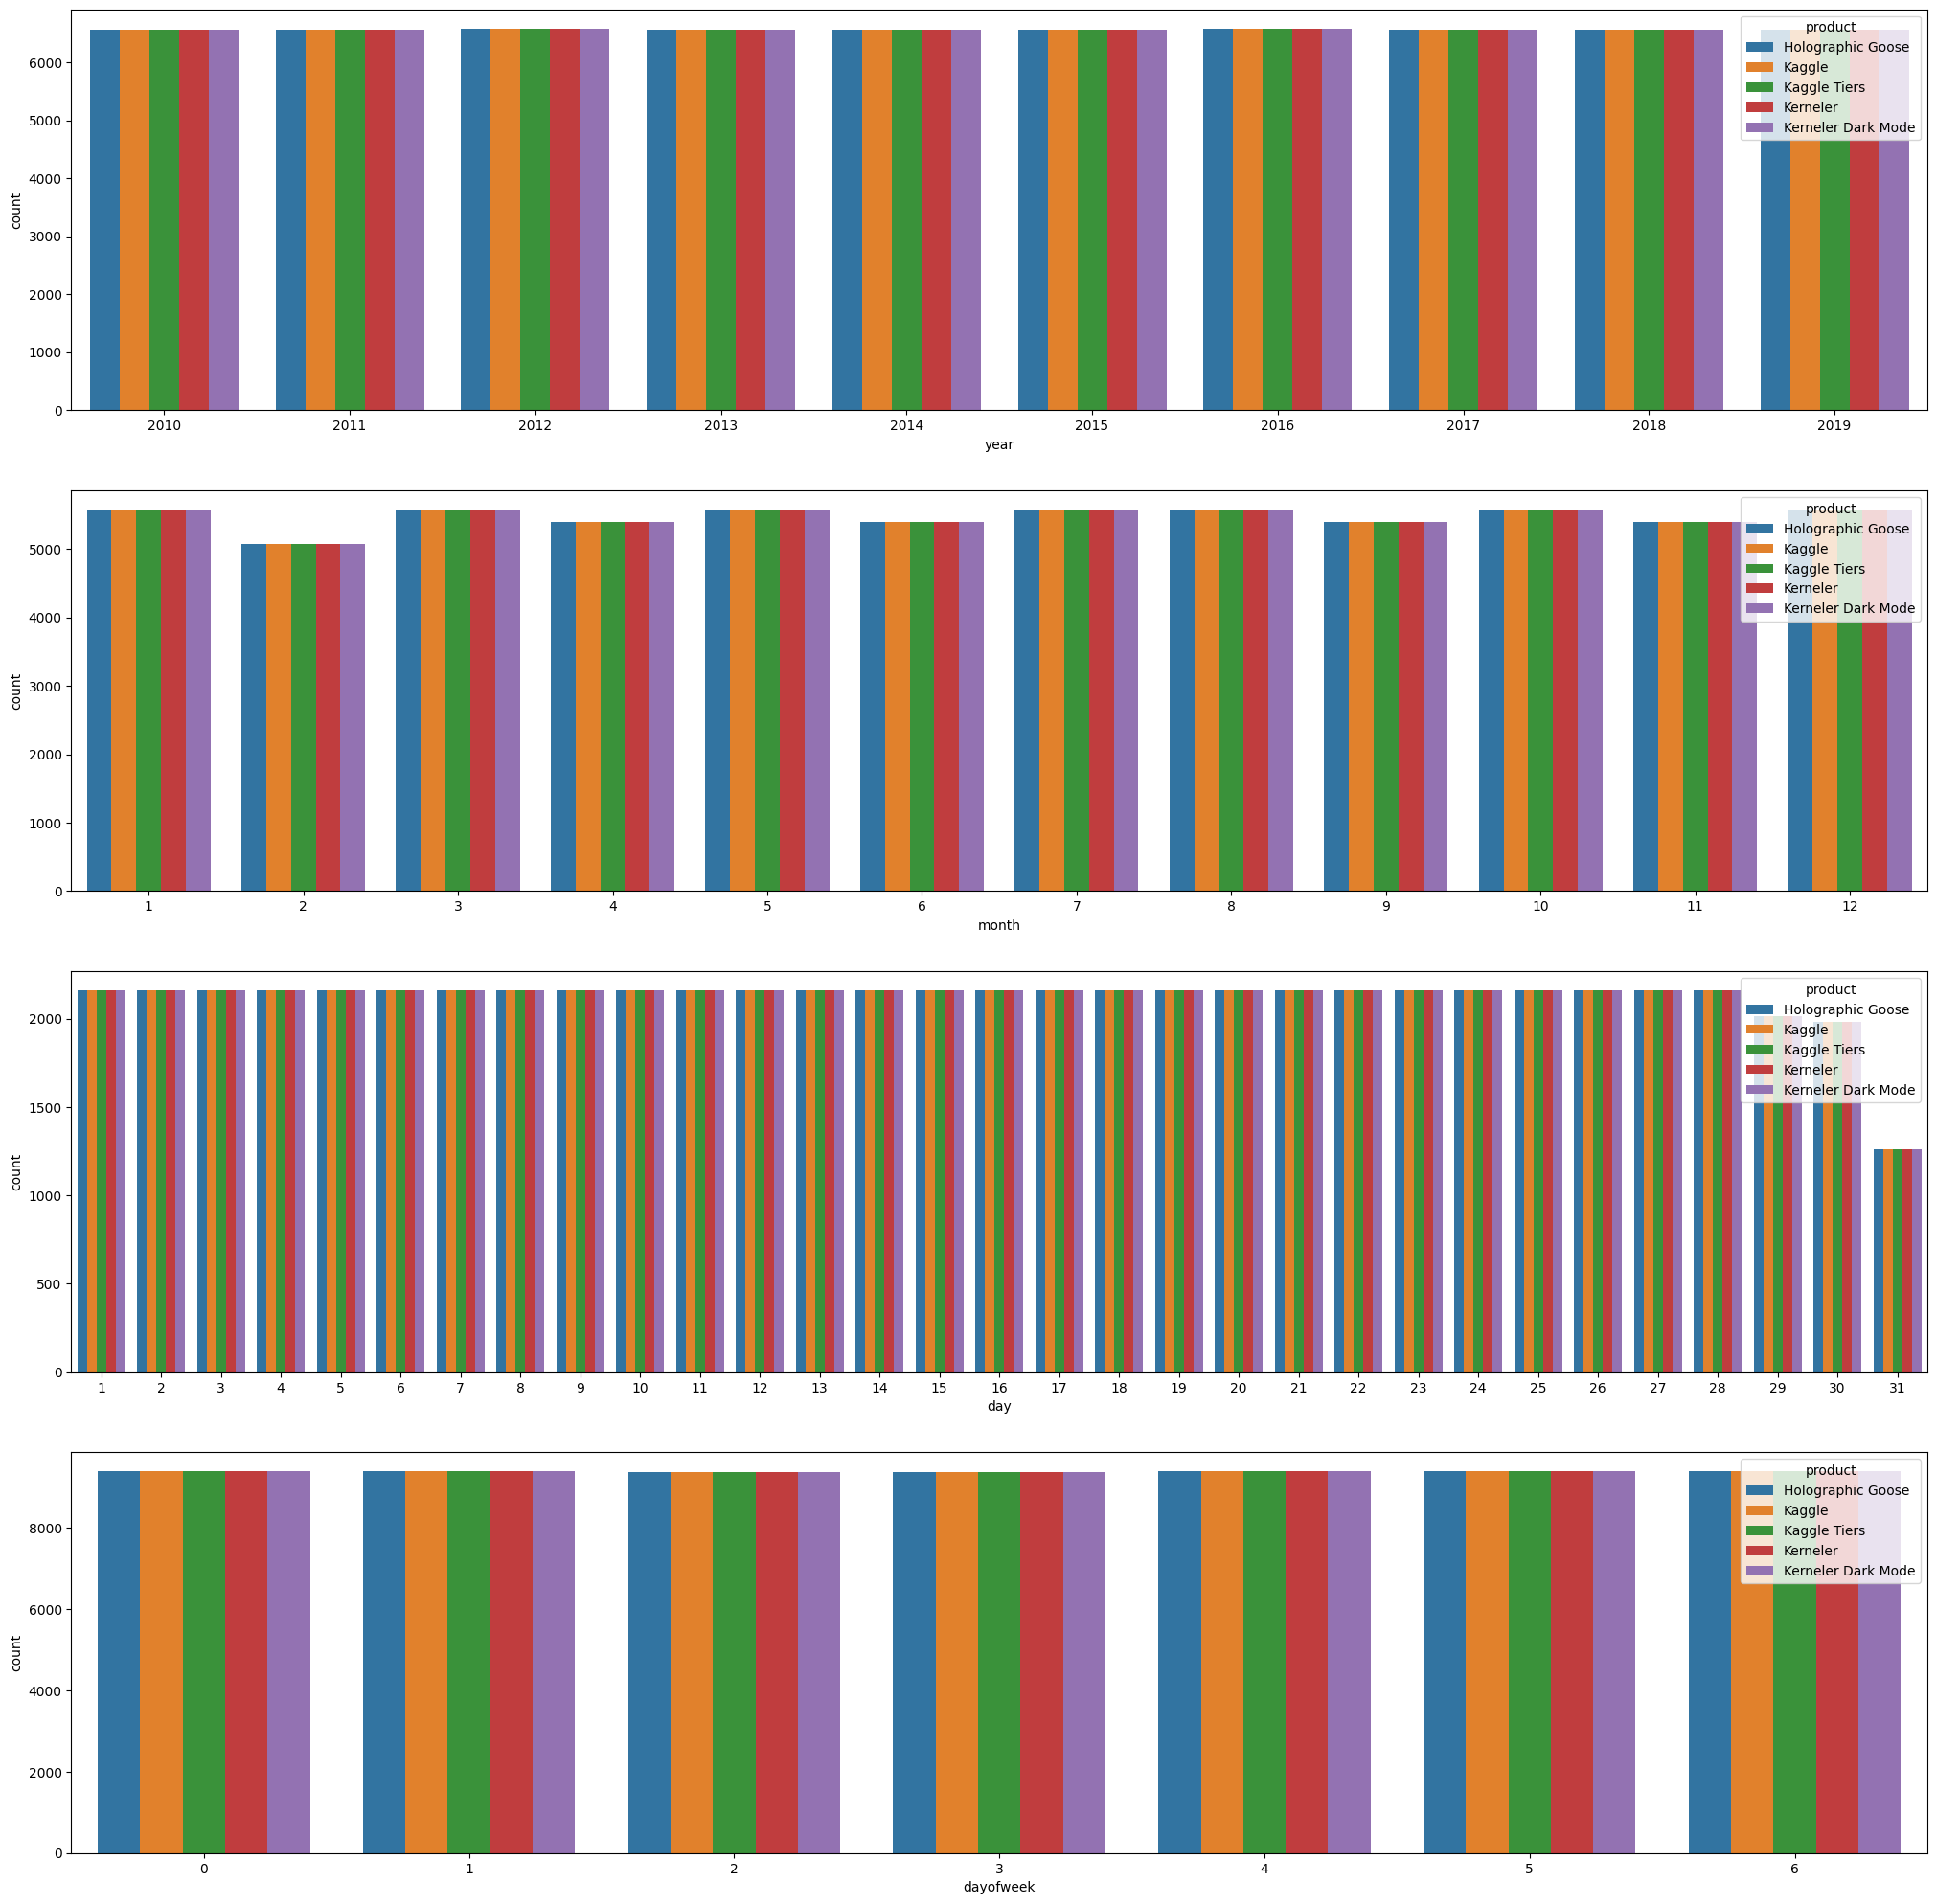

In [97]:
fig, axs = plt.subplots(figsize=(25, 25), nrows=4)

sns.countplot(data,x="year",hue="product",ax=axs[0])
sns.countplot(data,x="month",hue="product",ax=axs[1])
sns.countplot(data,x="day",hue="product",ax=axs[2])
sns.countplot(data,x="dayofweek",hue="product",ax=axs[3])

Same here for products as well. Since the count distribution is similar across all categories, it means that there is data being recorded consistently every day for all the categories. This a surely a positive for this dataset as the data is highly consistent and not biased in this regard. It is also interesting to note that we see similar cyclic patterns here as well. However, when the date is nearing the end of month we almost see an exponential drop off in sales. This is likely because of paycheck constraints that people have to deal with. 

In [100]:
data = data.drop('date', axis=1)

In [101]:
data.head()

,id,country,store,product,num_sold,year,month,day,dayofweek,days_since_start
0,0,Canada,Discount Stickers,Holographic Goose,NaN,2010,1,1,4,0
1,1,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,4,0
2,2,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,4,0
3,3,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,4,0
4,4,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,4,0


In [117]:
data["country"] = data["country"].astype('category').cat.codes
data["store"] = data["store"].astype('category').cat.codes
data["product"] = data["product"].astype('category').cat.codes

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328680 entries, 0 to 328679
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                328680 non-null  int64  
 1   country           328680 non-null  int8   
 2   store             328680 non-null  int8   
 3   product           328680 non-null  int8   
 4   num_sold          221259 non-null  float64
 5   year              328680 non-null  int32  
 6   month             328680 non-null  int32  
 7   day               328680 non-null  int32  
 8   dayofweek         328680 non-null  int32  
 9   days_since_start  328680 non-null  int64  
dtypes: float64(1), int32(4), int64(2), int8(3)
memory usage: 13.5 MB


Text(0.5, 1.0, 'Mutual Information vs. Target')

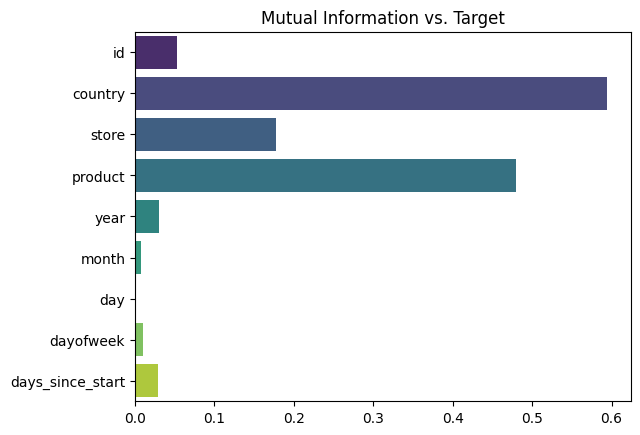

In [136]:
from sklearn.feature_selection import mutual_info_regression

no_nan = data.dropna()
y = no_nan[target_column]
no_nan = no_nan.drop(target_column, axis=1)

X = no_nan

mutual_info_values = mutual_info_regression(X, y, n_jobs=-1)
sns.barplot(x=mutual_info_values, y=no_nan.columns.values, palette="viridis")
plt.title("Mutual Information vs. Target")

This is the mutual information plot against the num_sold target variable. Based on this plot, we see that 3 categories: country, store and product have the biggest influence on the final sold product counts. In fact, country and product matter a lot compared to store. This is intuitive due to geographical advantages and product popularity. Even the store plays a role. This implies that different stores are designed for different purposes. My guess is that some stores focus on selling less stickers but for higher prices overall. This is indicative of Discount Stickers store which is similar. Then we see Premium Sticker Sales stores which sell more stickers in bulk so overall it's cheaper in bulk. This is a similar strategy to Costco.